In [13]:
import warnings, json, os, datetime as dt
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

plt.style.use("seaborn-v0_8")

# 📥 1. Load data

In [14]:
# Cell 1
df = pd.read_csv("mobile_game_inapp_purchases.csv") 
df.head()

,UserID,Age,Gender,Country,Device,GameGenre,SessionCount,AverageSessionLength,SpendingSegment,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,PaymentMethod,LastPurchaseDate
0,c9889ab0-9cfc-4a75-acd9-5eab1df0015c,49.0,Male,Norway,Android,Battle Royale,9,12.83,Minnow,11.40,28.0,Apple Pay,2025-03-19
1,7c9e413c-ecca-45f2-a780-2826a07952a2,15.0,Male,Switzerland,iOS,Action RPG,11,19.39,Minnow,6.37,18.0,Debit Card,2025-06-08
2,fd61e419-1a92-4f43-a8c7-135842ad328a,23.0,Male,China,Android,Fighting,9,8.87,Minnow,15.81,30.0,Apple Pay,2025-06-02
3,bdb7f6d1-ff9a-468c-afe7-43f32a94293e,31.0,Male,Mexico,Android,Racing,12,19.56,Minnow,13.49,9.0,Debit Card,2025-04-01
4,aa7eec14-4846-47b9-b879-9c98038cda04,37.0,Female,India,Android,Battle Royale,10,15.23,Minnow,10.86,15.0,Paypal,2025-05-05


# 🧹 2. Basic inspection & cleaning

In [15]:
# Cell 2
print(df.shape)
display(df.info())
display(df.isna().sum().sort_values(ascending=False).head(15))

(3024, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   UserID                         3024 non-null   object 
 1   Age                            2964 non-null   float64
 2   Gender                         2964 non-null   object 
 3   Country                        2964 non-null   object 
 4   Device                         2964 non-null   object 
 5   GameGenre                      2964 non-null   object 
 6   SessionCount                   3024 non-null   int64  
 7   AverageSessionLength           3024 non-null   float64
 8   SpendingSegment                3024 non-null   object 
 9   InAppPurchaseAmount            2888 non-null   float64
 10  FirstPurchaseDaysAfterInstall  2888 non-null   float64
 11  PaymentMethod                  2888 non-null   object 
 12  LastPurchaseDate               2888 n

None

LastPurchaseDate                 136
InAppPurchaseAmount              136
FirstPurchaseDaysAfterInstall    136
PaymentMethod                    136
Age                               60
GameGenre                         60
Device                            60
Gender                            60
Country                           60
UserID                             0
SpendingSegment                    0
SessionCount                       0
AverageSessionLength               0
dtype: int64

In [16]:
# Cell 3 ─── quick fixes
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['InAppPurchaseAmount'] = pd.to_numeric(df['InAppPurchaseAmount'], errors='coerce')
df['FirstPurchaseDaysAfterInstall'] = pd.to_numeric(df['FirstPurchaseDaysAfterInstall'], errors='coerce')
# drop rows with *no* purchase amount when modelling revenue
df_revenue = df.dropna(subset=['InAppPurchaseAmount'])

# 📊 3. Descriptive analytics

In [17]:
# Cell 4 ─── summary
summary = df_revenue.describe(include='all').T
summary['missing %'] = (df_revenue.isna().mean()*100).round(1)
summary.sort_values('missing %', ascending=False).head()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing %
Country,2828,27,India,234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1
Gender,2829,3,Male,1736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
GameGenre,2831,15,Simulation,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
Device,2832,2,Android,1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9
Age,2835.0,NaN,NaN,NaN,33.492416,11.963521,13.0,23.0,33.0,44.0,54.0,1.8


# univariate plots

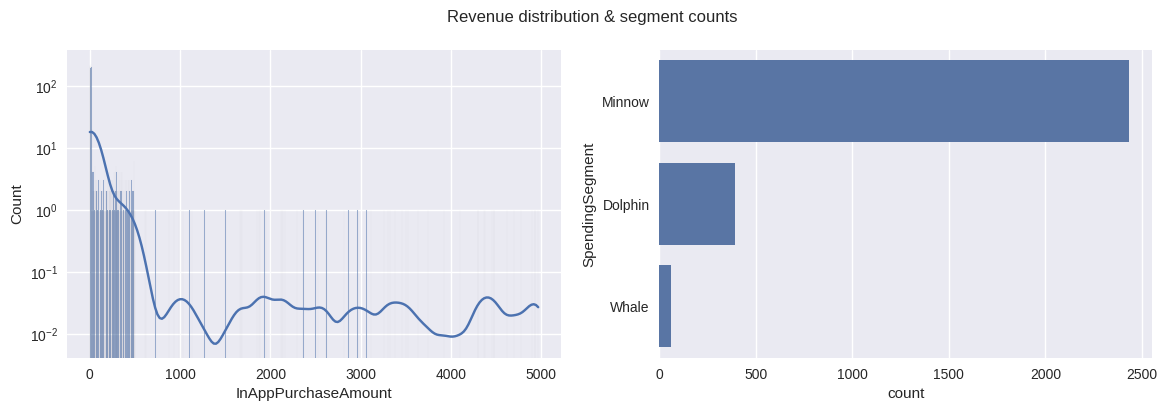

In [18]:
# Cell 5 ─── univariate plots
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_revenue['InAppPurchaseAmount'], kde=True, ax=ax[0])
ax[0].set_yscale('log')
sns.countplot(y='SpendingSegment', data=df_revenue, order=['Minnow','Dolphin','Whale'], ax=ax[1])
plt.suptitle("Revenue distribution & segment counts")
plt.show()

# bivariate: segment vs. numeric features

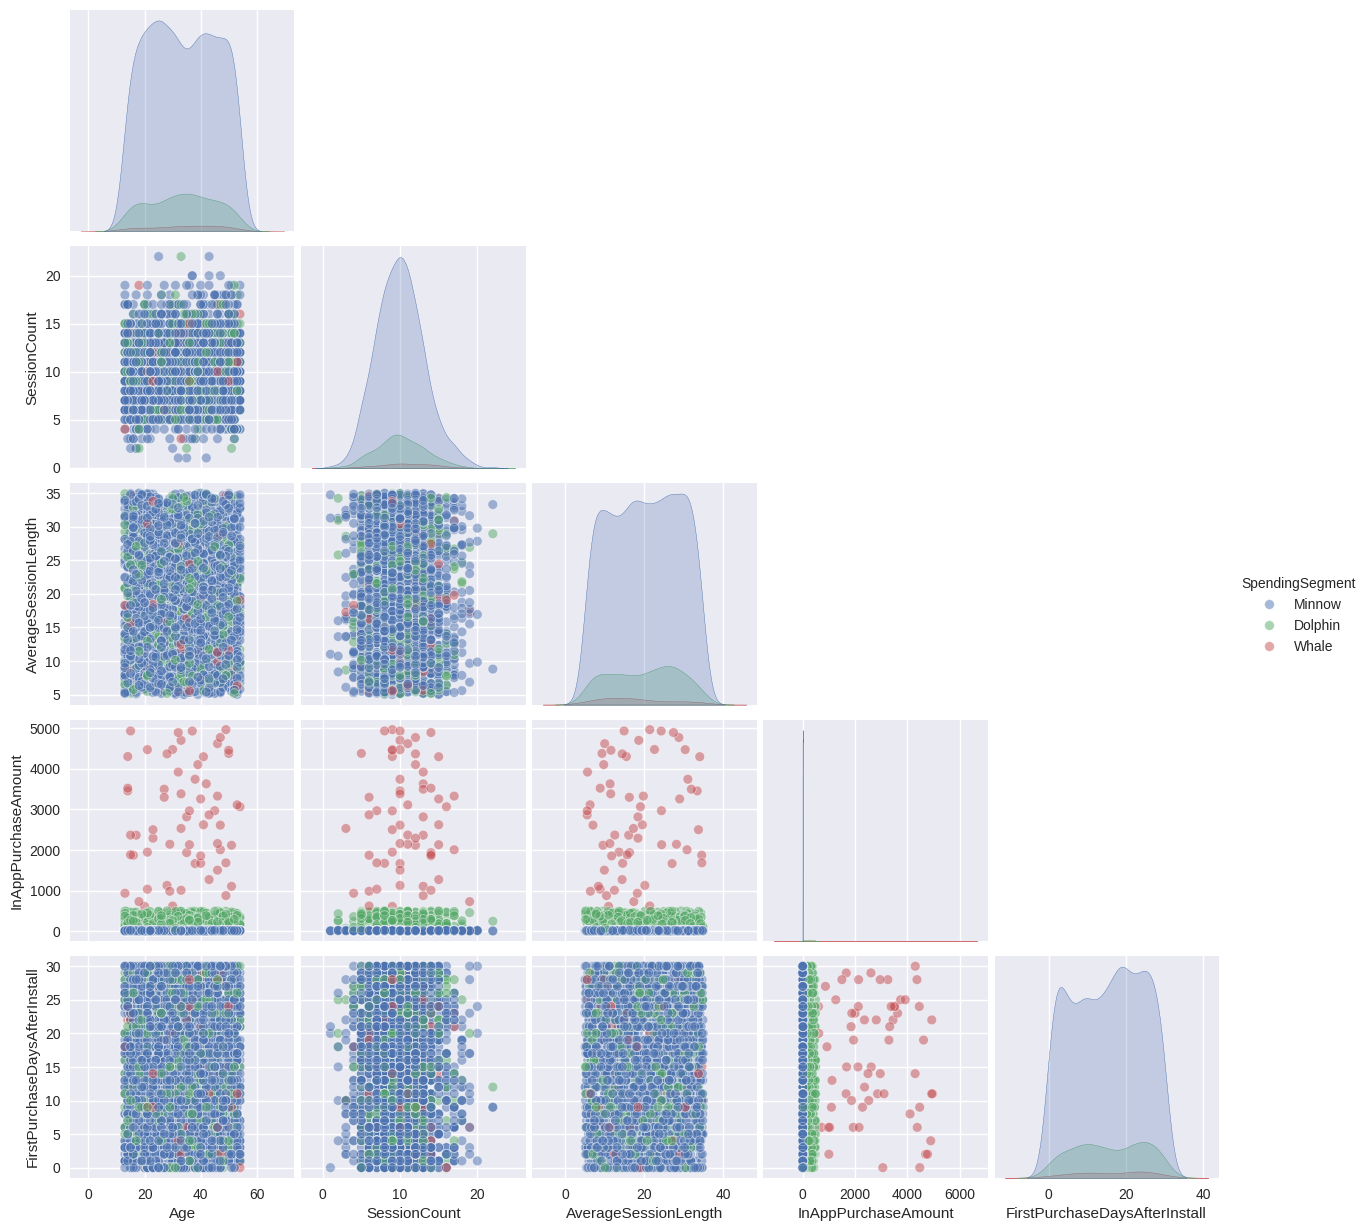

In [19]:
# Cell 6 ─── bivariate: segment vs. numeric features
num_cols = ['Age','SessionCount','AverageSessionLength','InAppPurchaseAmount','FirstPurchaseDaysAfterInstall']
sns.pairplot(df_revenue[num_cols + ['SpendingSegment']], hue='SpendingSegment',
             plot_kws={'alpha':0.5}, corner=True)
plt.show()

# 🔍 4. Feature engineering

In [20]:
# Cell 7
df_revenue['log_spend'] = np.log1p(df_revenue['InAppPurchaseAmount'])
df_revenue['AgeGroup'] = pd.cut(df_revenue['Age'], bins=[0,18,25,35,45,100], labels=['<18','18-24','25-34','35-44','45+'])
df_revenue['Device_OS'] = df_revenue['Device'].astype(str) + "_" + df_revenue['GameGenre'].astype(str)

# 🤖 5. Predictive modelling – Will a user become a Whale?

In [21]:
# Cell 8 ─── prepare
df_model = df_revenue.dropna(subset=['SpendingSegment'])
df_model['is_whale'] = (df_model['SpendingSegment'] == 'Whale').astype(int)

X = df_model[['Age','SessionCount','AverageSessionLength','FirstPurchaseDaysAfterInstall','Gender','Country','Device','GameGenre']]
y = df_model['is_whale']

categorical = ['Gender','Country','Device','GameGenre']
numeric     = ['Age','SessionCount','AverageSessionLength','FirstPurchaseDaysAfterInstall']

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', SimpleImputer(strategy='median'), numeric)  # <-- impute numeric
])

clf = Pipeline([
    ('prep', pre),
    ('gb', GradientBoostingClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

clf.fit(X_train, y_train)

,steps,"[('prep', ...), ('gb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
# Cell 9 ─── evaluation
print(classification_report(y_test, clf.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       706
           1       0.00      0.00      0.00        16

    accuracy                           0.97       722
   macro avg       0.49      0.50      0.49       722
weighted avg       0.96      0.97      0.96       722

ROC-AUC: 0.5037181303116147


# 🧪 6. Quick hyper-parameter tuning

In [24]:
# Cell 10
param_grid = {
    'gb__n_estimators':[100,200],
    'gb__learning_rate':[0.05,0.1],
    'gb__max_depth':[2,3]
}
grid = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best ROC-AUC:", grid.best_score_.round(3), grid.best_params_)

Best ROC-AUC: 0.583 {'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 100}


# 📈 7. Save artefacts

In [28]:
# Cell 11
df_revenue.to_parquet("clean_game_data.parquet")
clean_data = grid.best_estimator_.named_steps['prep'].get_feature_names_out().T

#  Feature-importance plot for the encoded features

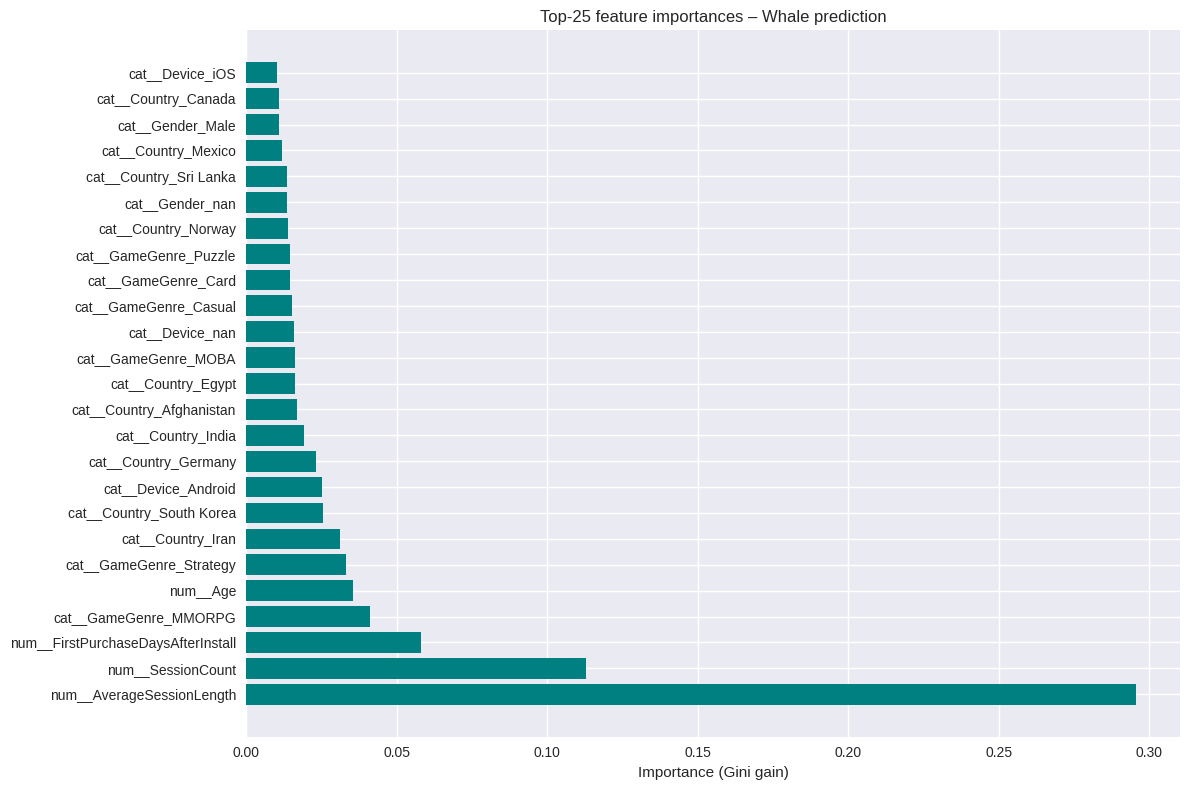

In [30]:
# Cell – Feature-importance plot for the encoded features
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1.  Grab the trained booster and the feature names
# -------------------------------------------------
booster = clf.named_steps['gb']                         # or clf.best_estimator_.named_steps['gb']
feature_names = clean_data

# -------------------------------------------------
# 2.  Build a tidy DataFrame for the top-25 features
# -------------------------------------------------
imp = booster.feature_importances_
top_idx = np.argsort(imp)[-25:]                 # indices of 25 largest
top_imp = imp[top_idx]
top_names = feature_names[top_idx]

# -------------------------------------------------
# 3.  Plot
# -------------------------------------------------
plt.figure(figsize=(12, 8))
plt.barh(top_names, top_imp, color='teal')
plt.gca().invert_yaxis()                        # highest at top
plt.title('Top-25 feature importances – Whale prediction')
plt.xlabel('Importance (Gini gain)')
plt.tight_layout()
plt.show()

# 🐋  Revenue distribution & whale cut-off

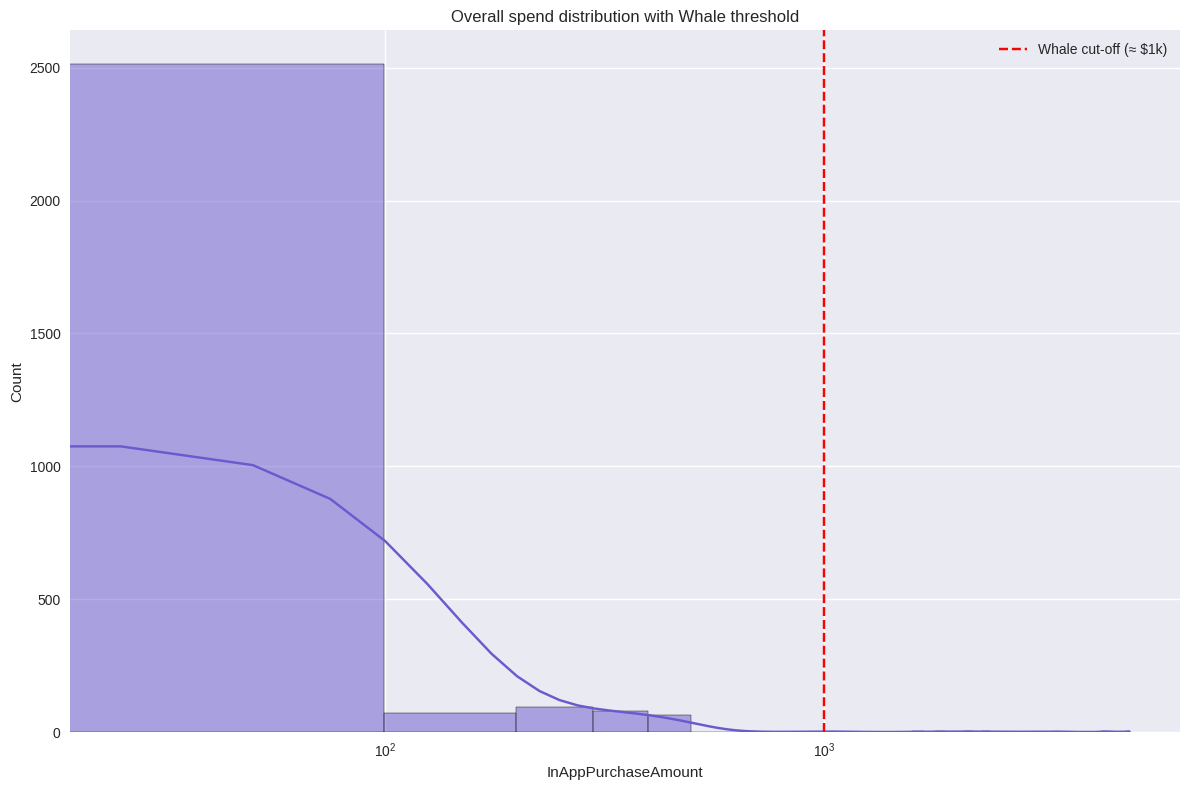

In [32]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=df_revenue, x='InAppPurchaseAmount', bins=50, kde=True, color='slateblue')
ax.set_xscale('log')
ax.axvline(1000, ls='--', c='red', label='Whale cut-off (≈ $1k)')
ax.set_title('Overall spend distribution with Whale threshold')
ax.legend()
plt.tight_layout(); plt.show()

# 📊  Segment counts & proportions

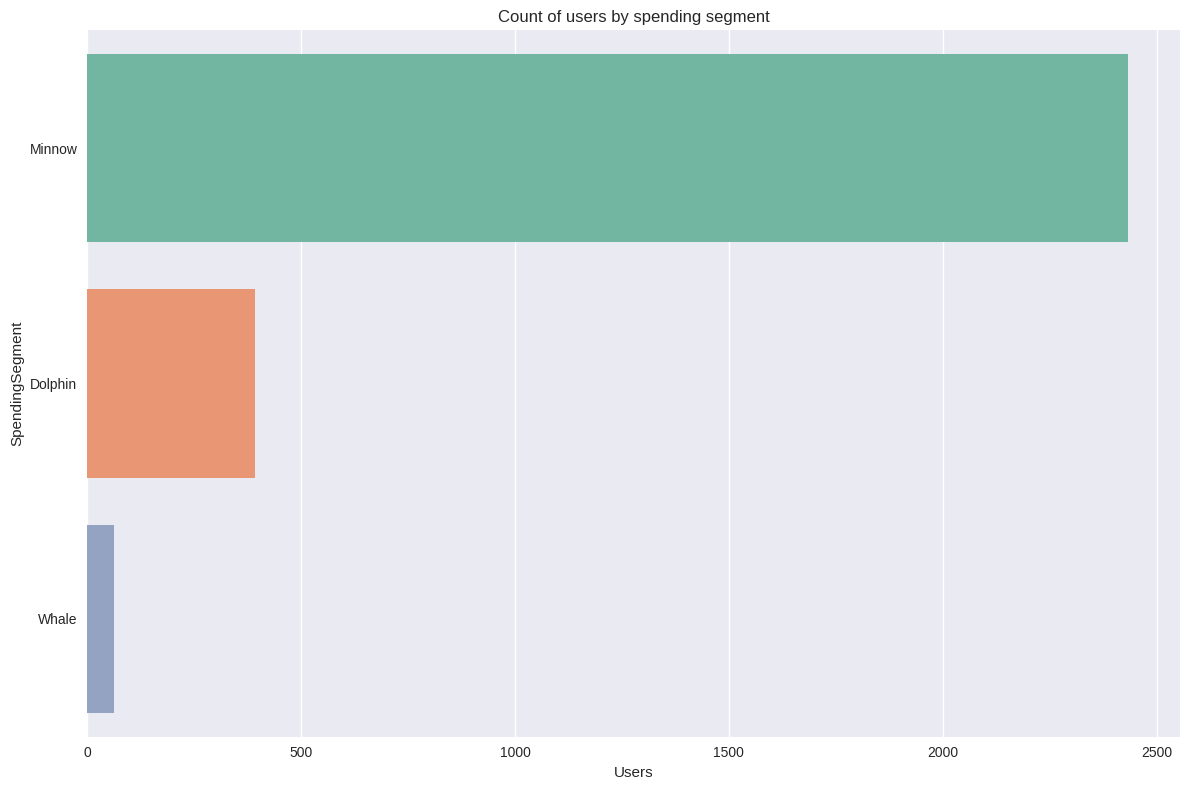

In [39]:
order = ['Minnow', 'Dolphin', 'Whale']
plt.figure(figsize=(12, 8))
sns.countplot(y='SpendingSegment', data=df_revenue, order=order, palette='Set2')
plt.title('Count of users by spending segment')
plt.xlabel('Users'); plt.tight_layout(); plt.show()


# Proportions

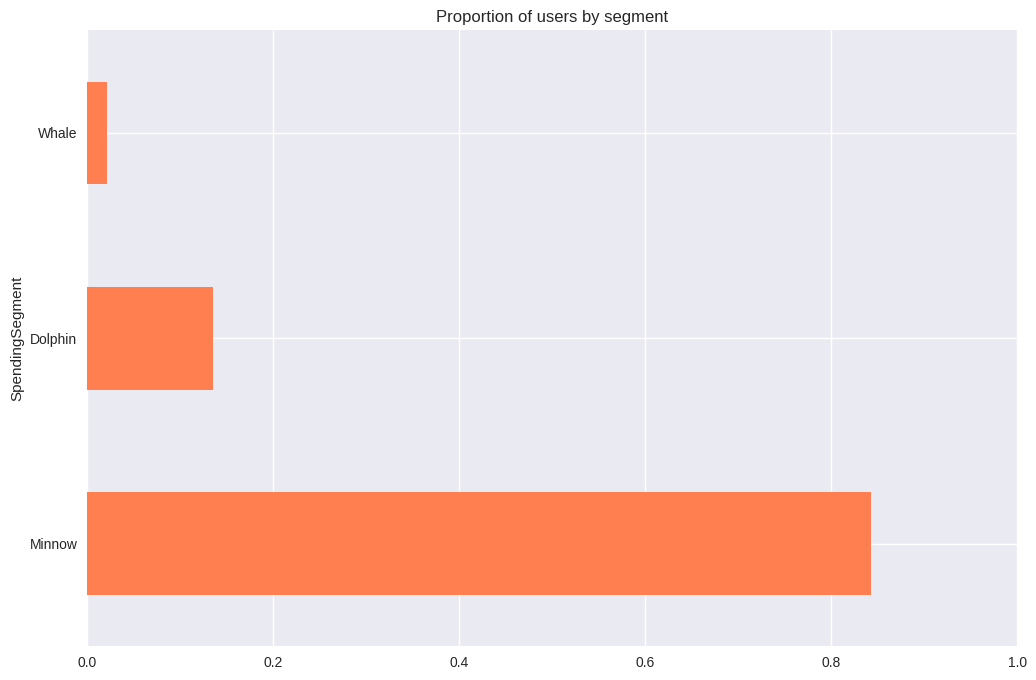

In [ ]:
plt.figure(figsize=(12, 8))
seg_prop = df_revenue['SpendingSegment'].value_counts(normalize=True).loc[order]
seg_prop.plot(kind='barh', color='coral')
plt.title('Proportion of users by segment'); plt.gca().set_xlim(0,1); plt.show()